In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import nltk
nltk.download('wordnet')
import pandas as pd
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/data.txt',sep="\t",header=None)
data.columns = ["label","text"]
data.head()

,label,text
0,1,neil burger here succeeded in making the myste...
1,0,it is a visual rorschach test and i must have ...
2,0,the only way to tolerate this insipid brutally...
3,0,scores no points for originality wit or intell...
4,0,it would take a complete moron to foul up a sc...


In [6]:
X_train = pd.read_csv("/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/X_train.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/X_test.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/y_train.csv")
y_test =  pd.read_csv('/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/y_test.csv')

In [80]:
print(y_train.value_counts())
print(y_test.value_counts())

label
1    205
0    195
Name: count, dtype: int64
label
1    51
0    49
Name: count, dtype: int64


In [7]:
import numpy as np
X_train = X_train["text"]
X_test = X_test["text"]
y_train = y_train["label"]
y_test = y_test["label"]

In [8]:
X_train_embeddings = SentenceTransformer("intfloat/multilingual-e5-large-instruct").encode(X_train.tolist(),batch_size=32,show_progress_bar=True)
X_test_embeddings = SentenceTransformer("intfloat/multilingual-e5-large-instruct").encode(X_test.tolist(),batch_size=32,show_progress_bar=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
#Embedding kaydetme
np.save(f"/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/embedding_orj_train.npy", X_train_embeddings)
np.save(f"/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/embedding_orj_test.npy", X_test_embeddings)

print(f"Embedding kaydedildi!")

Embedding kaydedildi!


In [ ]:
# Embedding'leri yükleme
X_train_embeddings = np.load(f"/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/embedding_orj_train.npy")
X_test_embeddings = np.load(f"/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/embedding_orj_test.npy")

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,f1_score
#Base model
model = RandomForestClassifier()
model.fit(X_train_embeddings, y_train)
y_pred = model.predict(X_test_embeddings)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

[[46  3]
 [ 7 44]]
Accuracy: 0.9
F1 Score: 0.8999199679871949
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        49
           1       0.94      0.86      0.90        51

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



### Synonym Replacement

In [11]:
import random
from nltk.corpus import wordnet
from scipy.stats import mode

# get_synonyms fonksiyonu
def get_synonyms(word):
    """WordNet kullanarak eş anlamlı kelimeleri döndürür."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

# Synonym Replacement Fonksiyonu
def synonym_replacement(words, n):
    """Kelime listesinde rastgele kelimeleri eş anlamlılarıyla değiştirir."""
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

# Augmentasyon ve Karar Birleştirme
def augment_and_evaluate_with_embeddings(X_test, y_test, technique, num_aug=3):
    """Seçilen augmentasyon tekniğiyle test verisini genişlet, embedding oluştur ve karar birleştirme uygula."""
    augmented_sentences = []
    for sentence in X_test:
        words = sentence.split()
        num_words = len(words)
        n = max(1, int(0.1 * num_words))  # Her augmentasyon için kullanılan kelime sayısı
        if technique == "synonym_replacement":
            augmented = [synonym_replacement(words, n) for _ in range(num_aug)]
        # Diğer teknikler (random_insertion, random_swap, random_deletion) buraya eklenebilir.
        augmented_sentences.extend([" ".join(sent) for sent in augmented])

    # e5-large ile embedding oluştur
    embedding_model = SentenceTransformer("intfloat/multilingual-e5-large-instruct")
    X_test_augmented_embeddings = embedding_model.encode(augmented_sentences, batch_size=32, show_progress_bar=True)

    # Orijinal ve augment edilmiş verileri birleştir
    augmented_predictions = model.predict(X_test_augmented_embeddings)  # Augmente edilmiş verilerin tahminleri
    original_predictions = model.predict(X_test_embeddings)  # Orijinal test verisinin tahminleri

    # Augmented tahminlerini orijinal test verileriyle eşleştir
    augmented_predictions = augmented_predictions.reshape(len(X_test), num_aug)  # Her test örneği için `num_aug` tahmin

    # Karar birleştirme (Majority Voting)
    final_predictions = []
    for i in range(len(X_test)):
      combined_predictions = list(augmented_predictions[i]) + [original_predictions[i]]  # Augmented + Orijinal
      final_decision = mode(combined_predictions, keepdims=True).mode[0]  # Çoğunluk kararı (tek değer alınıyor)
      final_predictions.append(final_decision)

    # Performansı değerlendirme
    cm = confusion_matrix(y_test, final_predictions)
    print(cm)
    print(f"\nEvaluation for {technique} with e5-large Embeddings and Majority Voting:\n")
    print("Accuracy:",accuracy_score(y_test, final_predictions))
    print("F1 Score:",f1_score(y_test, final_predictions, average='weighted'))
    print("Classification Report:")
    print(classification_report(y_test, final_predictions))
    return X_test_augmented_embeddings, original_predictions, augmented_predictions, final_predictions

X_test_augmented_embeddings, original_predictions, augmented_predictions, final_predictions = augment_and_evaluate_with_embeddings(X_test, y_test, technique="synonym_replacement",num_aug=3)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

[[49  0]
 [ 9 42]]

Evaluation for synonym_replacement with e5-large Embeddings and Majority Voting:

Accuracy: 0.91
F1 Score: 0.9094302080192945
Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.92        49
           1       1.00      0.82      0.90        51

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100



In [31]:
# Yanlış tahmin edilen indeksleri belirle
incorrect_indices = [i for i, (pred, true) in enumerate(zip(final_predictions, y_test)) if pred != true]

# Yanlış tahmin edilen örnekleri görüntüle
incorrect_samples = { "Original Pred": [original_predictions[i] for i in incorrect_indices],
    "Augmented Variants": [augmented_predictions[i].tolist() for i in incorrect_indices],
    "Final Prediction": [final_predictions[i] for i in incorrect_indices],
    "True Label": [y_test[i] for i in incorrect_indices],
}
incorrect_df = pd.DataFrame(incorrect_samples)
incorrect_df

,Original Pred,Augmented Variants,Final Prediction,True Label
0,0,"[0, 0, 0]",0,1
1,1,"[0, 0, 0]",0,1
2,0,"[0, 0, 0]",0,1
3,0,"[1, 0, 1]",0,1
4,0,"[0, 0, 0]",0,1
5,0,"[0, 0, 0]",0,1
6,1,"[0, 0, 1]",0,1
7,0,"[0, 0, 0]",0,1
8,0,"[0, 0, 1]",0,1


In [69]:
import random
from nltk.corpus import wordnet
from scipy.stats import mode

# get_synonyms fonksiyonu
def get_synonyms(word):
    """WordNet kullanarak eş anlamlı kelimeleri döndürür."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

# Synonym Replacement Fonksiyonu
def synonym_replacement(words, n):
    """Kelime listesinde rastgele kelimeleri eş anlamlılarıyla değiştirir."""
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

In [68]:
def augment_data(X_test, technique, num_aug=3):
    """Seçilen augmentasyon tekniğiyle test verisini genişletir."""
    augmented_sentences = []
    for sentence in X_test:
        words = sentence.split()
        num_words = len(words)
        n = max(1, int(0.1 * num_words))  # Her augmentasyon için kullanılan kelime sayısı
        if technique == "synonym_replacement":
            augmented = [synonym_replacement(words, n) for _ in range(num_aug)]
        # Diğer teknikler buraya eklenebilir.
        augmented_sentences.extend([" ".join(sent) for sent in augmented])
    return augmented_sentences



In [70]:
def generate_embeddings(sentences, embedding_model_name="intfloat/multilingual-e5-large-instruct"):
    """Verilen cümleler için embedding oluşturur."""
    embedding_model = SentenceTransformer(embedding_model_name)
    embeddings = embedding_model.encode(sentences, batch_size=32, show_progress_bar=True)
    return embeddings


In [71]:
def combine_predictions(original_predictions, augmented_predictions, strategy="majority_voting"):
    """Orijinal ve augment edilmiş tahminleri birleştirir."""
    if strategy == "majority_voting":
        augmented_predictions = augmented_predictions.reshape(len(original_predictions), -1)  # Her test örneği için tahminler
        final_predictions = []
        for i in range(len(original_predictions)):
            combined_predictions = list(augmented_predictions[i]) + [original_predictions[i]]
            final_decision = mode(combined_predictions, keepdims=True).mode[0]  # Çoğunluk kararı
            final_predictions.append(final_decision)
        return final_predictions
    else:
        raise ValueError(f"Unsupported strategy: {strategy}")


In [72]:
def evaluate_predictions(y_test, final_predictions):
    """Modelin performansını değerlendirir ve sonuçları yazdırır."""
    cm = confusion_matrix(y_test, final_predictions)
    print(cm)
    print("\nEvaluation Results:")
    print("Accuracy:", accuracy_score(y_test, final_predictions))
    print("F1 Score:", f1_score(y_test, final_predictions, average='weighted'))
    print("Classification Report:")
    print(classification_report(y_test, final_predictions))


In [14]:
# Augmentation
augmented_sentences = augment_data(X_test, technique="synonym_replacement", num_aug=3)

# Embedding
X_test_augmented_embeddings = generate_embeddings(augmented_sentences)
X_test_embeddings = generate_embeddings(X_test)

# Tahminler
original_predictions = model.predict(X_test_embeddings)
augmented_predictions = model.predict(X_test_augmented_embeddings)

# Karar Birleştirme
final_predictions = combine_predictions(original_predictions, augmented_predictions, strategy="majority_voting")

# Performans Değerlendirme
evaluate_predictions(y_test, final_predictions)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

[[47  2]
 [ 8 43]]

Evaluation Results:
Accuracy: 0.9
F1 Score: 0.8997596153846155
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        49
           1       0.96      0.84      0.90        51

    accuracy                           0.90       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.90      0.90       100



In [82]:
X_test[0]

'not everything in this ambitious comic escapade works but coppola along with his sister sofia is a real filmmaker '

In [15]:
augmented_sentences

['not everything in this ambitious comic escapade works but coppola along with his sister sofia live a real filmmaker',
 'not everything in this ambitious comic escapade works but coppola along with his sister sofia is a real movie_maker',
 'not everything in this ambitious comic escapade works but coppola along with his sister sofia is a literal filmmaker',
 'simply not campy enough',
 'just not camp enough',
 'just not campy enough',
 'has entirely the hallmarks of a movie designed strictly for children is home video a market then insatiable it absorbs entirely manner of game entertainment as long as year olds find it diverting',
 'has all the hallmarks of a movie designed strictly for children is home video a market so insatiate information_technology absorbs all manner of lame entertainment as long as year olds chance information_technology diverting',
 'has all the hallmarks of a movie designed strictly for children is home video a market and_then insatiable it absorbs all manner 

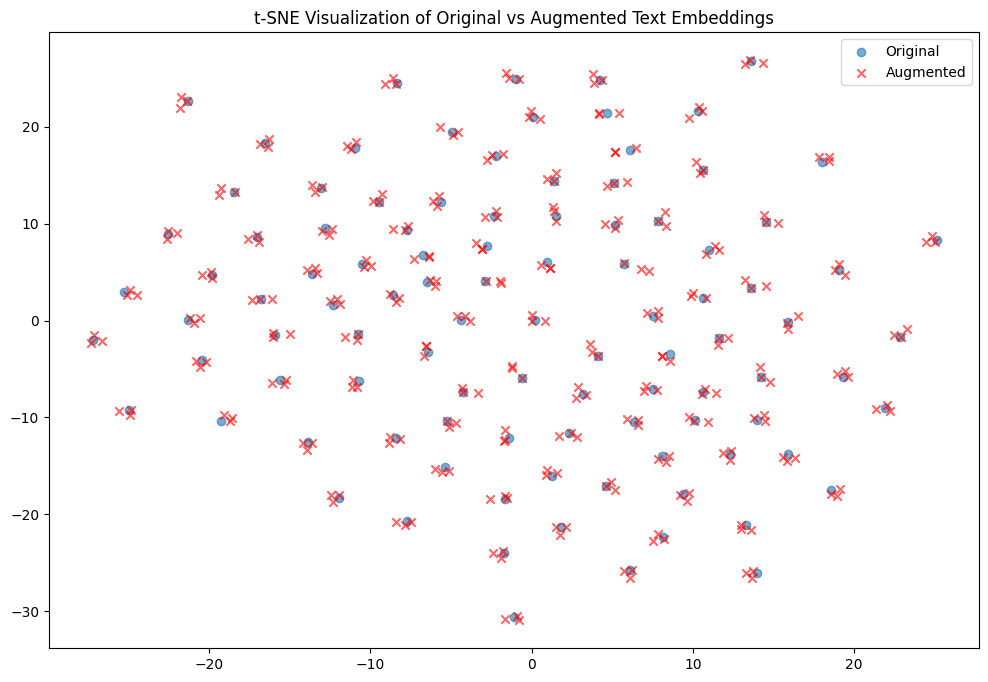

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(original_embeddings, augmented_embeddings, labels):
    """Original ve augment edilmiş metinlerin t-SNE ile görselleştirilmesi."""
    tsne = TSNE(n_components=2, random_state=42)
    combined_embeddings = np.vstack((original_embeddings, augmented_embeddings))
    tsne_results = tsne.fit_transform(combined_embeddings)

    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_results[:len(original_embeddings), 0], tsne_results[:len(original_embeddings), 1], label='Original', alpha=0.6)
    plt.scatter(tsne_results[len(original_embeddings):, 0], tsne_results[len(original_embeddings):, 1], label='Augmented', alpha=0.6, c='r',marker='x')
    plt.legend()
    plt.title('t-SNE Visualization of Original vs Augmented Text Embeddings')
    plt.show()

# t-SNE görselleştirmesi için fonksiyonu çağırma
plot_tsne(X_test_embeddings, X_test_augmented_embeddings, labels=y_test)


<ipython-input-19-57b55d38dfcb>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Her sınıfa farklı renk atanması


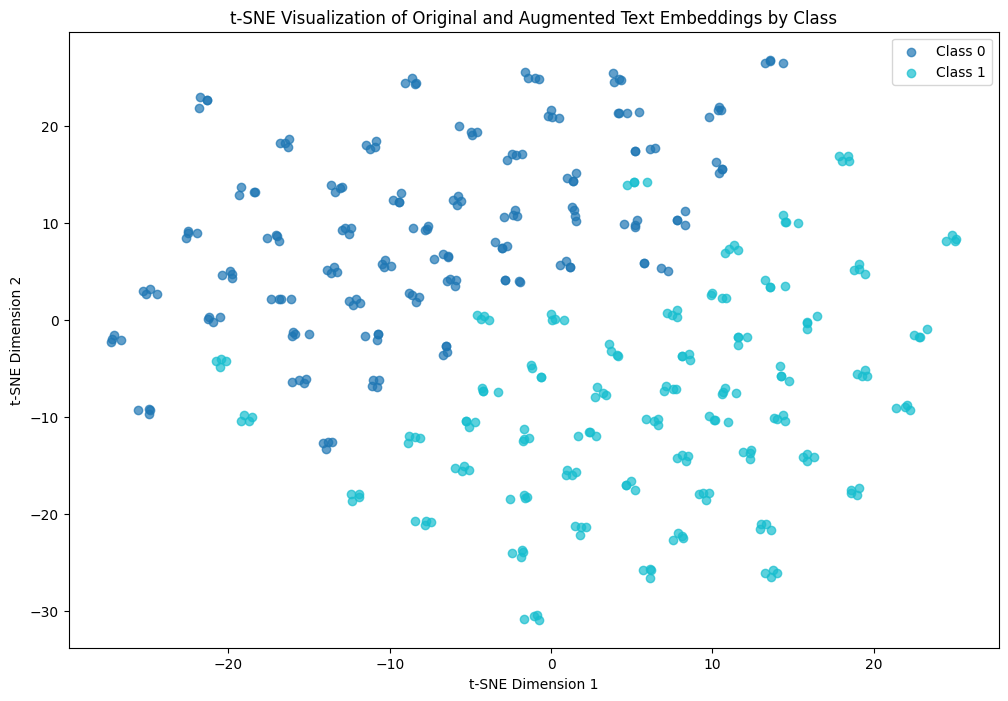

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne_with_labels_same_color(original_embeddings, augmented_embeddings, original_labels, augmented_labels):
    """Original ve augment edilmiş metinlerin aynı sınıf için aynı renkte görselleştirilmesi."""
    tsne = TSNE(n_components=2, random_state=42)

    # Embedding'leri ve etiketleri birleştiriyoruz
    combined_embeddings = np.vstack((original_embeddings, augmented_embeddings))
    combined_labels = np.hstack((original_labels, augmented_labels))

    # t-SNE ile 2D'ye indirgeme
    tsne_results = tsne.fit_transform(combined_embeddings)

    plt.figure(figsize=(12, 8))

    # Her sınıf için döngü
    unique_labels = np.unique(combined_labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Her sınıfa farklı renk atanması

    for label in unique_labels:
        idx = (combined_labels == label)
        plt.scatter(
            tsne_results[idx, 0],
            tsne_results[idx, 1],
            label=f'Class {label}',
            alpha=0.7,
            color=colors(label)
        )

    plt.legend()
    plt.title('t-SNE Visualization of Original and Augmented Text Embeddings by Class')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# t-SNE görselleştirmesi için fonksiyonu çağırma
plot_tsne_with_labels_same_color(
    X_test_embeddings,
    X_test_augmented_embeddings,
    original_labels=np.array(y_test),
    augmented_labels=np.array(y_test).repeat(3)  # Augmented veri için etiketleri çoğaltıyoruz
)


## 5 katına çıkarma

In [73]:
# Augmentation
augmented_sentences_5 = augment_data(X_test, technique="synonym_replacement", num_aug=5)

# Embedding
X_test_augmented_embeddings_5 = generate_embeddings(augmented_sentences_5)

# Tahminler
original_predictions = model.predict(X_test_embeddings)
augmented_predictions = model.predict(X_test_augmented_embeddings_5)

# Karar Birleştirme
final_predictions = combine_predictions(original_predictions, augmented_predictions, strategy="majority_voting")

# Performans Değerlendirme
evaluate_predictions(y_test, final_predictions)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

[[48  1]
 [ 6 45]]

Evaluation Results:
Accuracy: 0.93
F1 Score: 0.9298949054148734
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        49
           1       0.98      0.88      0.93        51

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [74]:
augmented_sentences_5

['not everything in this ambitious comic escapade works but coppola along with his sister Serdica is a real filmmaker',
 'not everything in this ambitious comic escapade works but coppola along with his sister sofia is a actual filmmaker',
 'not everything in this ambitious comic escapade works but coppola on with his sister sofia is a real filmmaker',
 'not everything in this ambitious comic escapade works but coppola along with his sister sofia is a real_number filmmaker',
 'not everything inward this ambitious comic escapade works but coppola along with his sister sofia is a real filmmaker',
 'simply not campy enough',
 'just not campy enough',
 'precisely not campy enough',
 'just not campy enough',
 'barely not campy enough',
 'has all the hallmarks of a movie designed strictly for children is home video a market thusly insatiable IT absorbs all manner of lame entertainment as long as year old find IT diverting',
 'has all the hallmarks of a flick project strictly for children is 

<ipython-input-76-341258f78ac3>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Her sınıfa farklı renk atanması


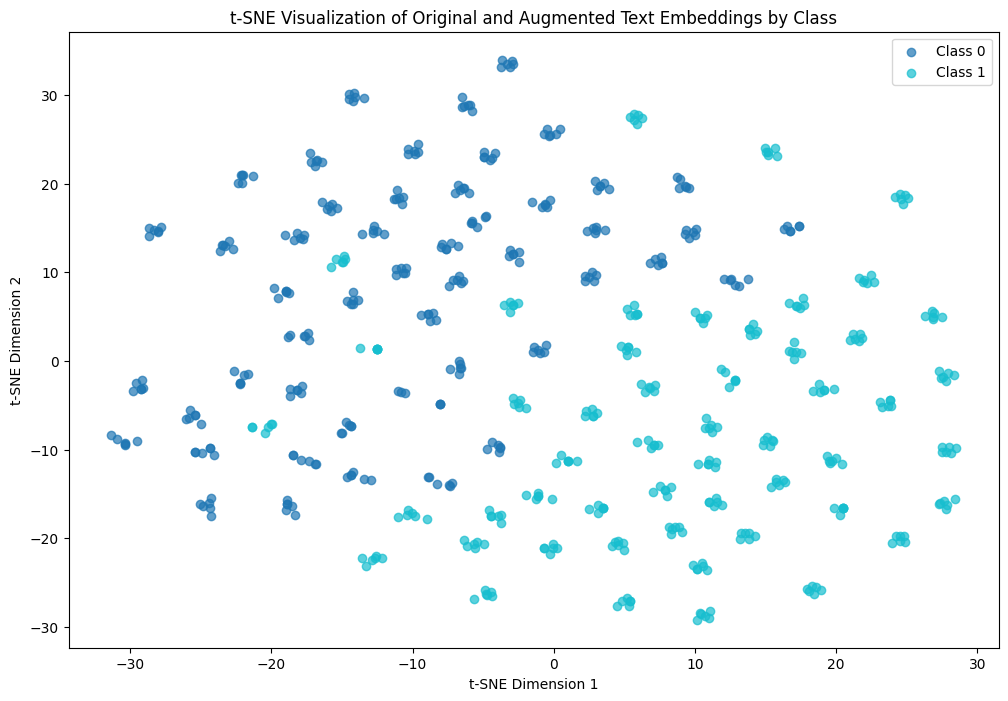

In [76]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne_with_labels_same_color(original_embeddings, augmented_embeddings, original_labels, augmented_labels):
    """Original ve augment edilmiş metinlerin aynı sınıf için aynı renkte görselleştirilmesi."""
    tsne = TSNE(n_components=2, random_state=42)

    # Embedding'leri ve etiketleri birleştiriyoruz
    combined_embeddings = np.vstack((original_embeddings, augmented_embeddings))
    combined_labels = np.hstack((original_labels, augmented_labels))

    # t-SNE ile 2D'ye indirgeme
    tsne_results = tsne.fit_transform(combined_embeddings)

    plt.figure(figsize=(12, 8))

    # Her sınıf için döngü
    unique_labels = np.unique(combined_labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Her sınıfa farklı renk atanması

    for label in unique_labels:
        idx = (combined_labels == label)
        plt.scatter(
            tsne_results[idx, 0],
            tsne_results[idx, 1],
            label=f'Class {label}',
            alpha=0.7,
            color=colors(label)
        )

    plt.legend()
    plt.title('t-SNE Visualization of Original and Augmented Text Embeddings by Class')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# t-SNE görselleştirmesi için fonksiyonu çağırma
plot_tsne_with_labels_same_color(
    X_test_embeddings,
    X_test_augmented_embeddings_5,
    original_labels=np.array(y_test),
    augmented_labels=np.array(y_test).repeat(5)  # Augmented veri için etiketleri çoğaltıyoruz
)


In [77]:
# Yanlış tahmin edilen indeksleri belirle
incorrect_indices = [i for i, (pred, true) in enumerate(zip(final_predictions, y_test)) if pred != true]

# Yanlış tahmin edilen örnekleri görüntüle
incorrect_samples = { "Original Pred": [original_predictions[i] for i in incorrect_indices],
    "Augmented Variants": [aug_predictions[i].tolist() for i in incorrect_indices],
    "Final Prediction": [final_predictions[i] for i in incorrect_indices],
    "True Label": [y_test[i] for i in incorrect_indices],
}
incorrect_df = pd.DataFrame(incorrect_samples)
incorrect_df

,Original Pred,Augmented Variants,Final Prediction,True Label
0,0,"[0, 1, 0, 0, 0]",0,1
1,0,"[0, 0, 1, 1, 0]",0,1
2,0,"[0, 0, 0, 0, 0]",0,1
3,0,"[0, 0, 1, 0, 0]",0,1
4,0,"[0, 0, 0, 0, 0]",1,0
5,0,"[1, 1, 1, 1, 1]",0,1
6,0,"[0, 0, 0, 0, 1]",0,1


## Back Translation

In [2]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.6 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=2f4df5f4b909963732f92cd99793bd368fef2d609f7579c68b3310cd0d6c6380
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Succ

In [10]:
from googletrans import Translator

# Back Translation için diller
languages = ['de', 'fr', 'es']  # Almanca, Fransızca, İspanyolca
translator = Translator()

def back_translate(text, lang):
    """
    Metni verilen dile çevirip tekrar İngilizceye çevirir.
    """
    try:
        # İngilizce -> Hedef Dil
        translated = translator.translate(text, src='en', dest=lang).text
        # Hedef Dil -> İngilizce
        back_translated = translator.translate(translated, src=lang, dest='en').text
        return back_translated
    except Exception as e:
        print(f"Error in translation: {e}")
        return text  # Çeviri başarısızsa orijinal metni döndür

def augment_data(data, languages):
    """
    Back translation ile sadece üretilmiş veriyi döndürür.
    """
    augmented_data = []
    for text in data:
        for lang in languages:
            augmented_text = back_translate(text, lang)
            augmented_data.append(augmented_text)
    return augmented_data


# Augmented veri oluşturma
augmented_data = augment_data(X_test, languages)

# Sonuçları yazdır
print("\nAugmented Data (Only Generated Texts):")
for idx, text in enumerate(augmented_data):
    print(f"{idx + 1}: {text}")

Error in translation: 'NoneType' object is not iterable
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'NoneType' object is not iterable
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object

In [12]:
backtranslation_augmented_test = pd.DataFrame({'text': augmented_data, 'label': y_test.repeat(3)})
X_back_translation_embeddings = SentenceTransformer("intfloat/multilingual-e5-large-instruct").encode(backtranslation_augmented_test['text'].tolist(),batch_size=32,show_progress_bar=True)
y_augmented = backtranslation_augmented_test['label']

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


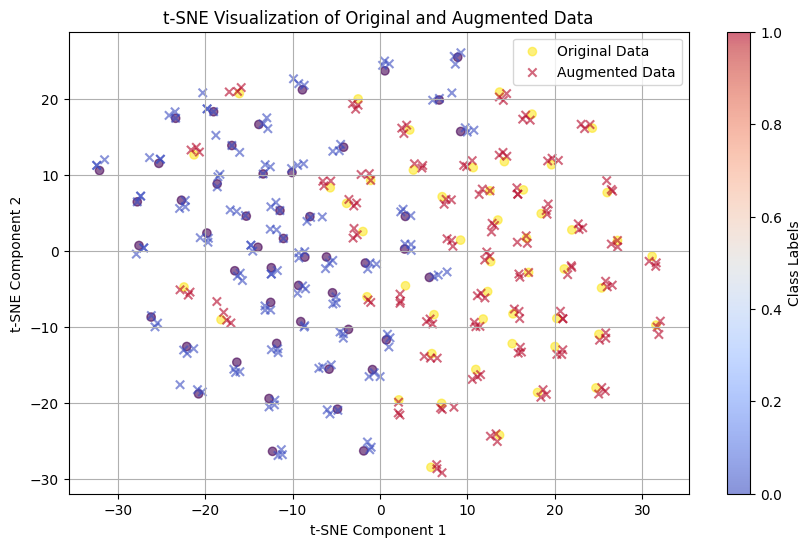

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_tsne(original_embeddings, augmented_embeddings, labels_original, labels_augmented):
    """
    t-SNE kullanarak orijinal ve üretilmiş embedding'leri görselleştirir.
    """
    # Orijinal ve augmented embedding'leri birleştirme
    combined_embeddings = np.vstack((original_embeddings, augmented_embeddings))
    combined_labels = np.concatenate((labels_original, labels_augmented))

    # t-SNE ile 2 boyuta indirge
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    reduced_embeddings = tsne.fit_transform(combined_embeddings)

    # Orijinal ve augmented verilerin ayırıcı indeksleri
    original_count = len(original_embeddings)
    augmented_count = len(augmented_embeddings)

    # Scatter plot için verileri ayır
    original_reduced = reduced_embeddings[:original_count]
    augmented_reduced = reduced_embeddings[original_count:]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(original_reduced[:, 0], original_reduced[:, 1], c=labels_original, cmap='viridis', label="Original Data", alpha=0.6)
    plt.scatter(augmented_reduced[:, 0], augmented_reduced[:, 1], c=labels_augmented, cmap='coolwarm', label="Augmented Data", alpha=0.6, marker='x')
    plt.colorbar(label="Class Labels")
    plt.title("t-SNE Visualization of Original and Augmented Data")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.grid()
    plt.show()

# Orijinal ve augmented verilerin görselleştirilmesi
visualize_tsne(
    original_embeddings=X_test_embeddings,
    augmented_embeddings=X_back_translation_embeddings,
    labels_original=y_test,
    labels_augmented=y_augmented
)

In [19]:
from scipy.stats import mode

# Augmented veri için tahminler
aug_predictions = model.predict(X_back_translation_embeddings)

# Orijinal test verisi için tahminler
original_predictions = model.predict(X_test_embeddings)

# Augmented tahminleri, her orijinal test örneğiyle eşleştir
# Augmented veriyi oluştururken her test örneği için 3 varyasyon yaptığınızdan bunu hesaba katıyoruz.
aug_predictions = aug_predictions.reshape(len(X_test), 3)  # Her test örneği için 3 tahmin

# Karar birleştirme (Majority Voting)
final_predictions = []
for i in range(len(original_predictions)):
    # Orijinal tahmin + 3 augment tahmini
    combined_predictions = list(aug_predictions[i]) + [original_predictions[i]]
    # En sık geçen sınıfı seç
    final_decision = mode(combined_predictions).mode
    final_predictions.append(final_decision)

# Performansı değerlendirme
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Birleştirilmiş tahminlerle doğruluk hesaplama
combined_accuracy = accuracy_score(y_test, final_predictions)
print(f"Combined Accuracy: {combined_accuracy}")

# Detaylı rapor
print("Classification Report:")
print(classification_report(y_test, final_predictions))

# Karışıklık matrisi
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(cm)

Combined Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        49
           1       1.00      0.78      0.88        51

    accuracy                           0.89       100
   macro avg       0.91      0.89      0.89       100
weighted avg       0.91      0.89      0.89       100

Confusion Matrix:
[[49  0]
 [11 40]]


In [20]:
# Yanlış tahmin edilen indeksleri belirle
incorrect_indices = [i for i, (pred, true) in enumerate(zip(final_predictions, y_test)) if pred != true]

# Yanlış tahmin edilen örnekleri görüntüle
incorrect_samples = { "Original Pred": [original_predictions[i] for i in incorrect_indices],
    "Augmented Variants": [aug_predictions[i].tolist() for i in incorrect_indices],
    "Final Prediction": [final_predictions[i] for i in incorrect_indices],
    "True Label": [y_test[i] for i in incorrect_indices],
}
incorrect_df = pd.DataFrame(incorrect_samples)
incorrect_df

,Original Pred,Augmented Variants,Final Prediction,True Label
0,0,"[1, 0, 0]",0,1
1,1,"[0, 0, 0]",0,1
2,1,"[0, 0, 1]",0,1
3,0,"[0, 0, 0]",0,1
4,1,"[0, 1, 0]",0,1
5,1,"[1, 0, 0]",0,1
6,0,"[0, 0, 0]",0,1
7,0,"[0, 0, 0]",0,1
8,1,"[0, 0, 0]",0,1
9,0,"[1, 0, 1]",0,1


In [24]:
from scipy.stats import mode
import numpy as np

# Augmented tahminleri yeniden şekillendir (her test örneği için 3 tahmin)
aug_predictions = aug_predictions.reshape(len(X_test), 3)

# Ağırlıklandırma
weight = 3  # Orijinal tahminlere verilecek ağırlık
final_predictions = []

for i in range(len(original_predictions)):
    # Orijinal tahmini ağırlıklandır
    weighted_original = [original_predictions[i]] * weight
    # Orijinal ve augmented tahminleri birleştir
    combined_predictions = list(aug_predictions[i]) + weighted_original
    # En sık geçen sınıfı seç
    final_decision = mode(combined_predictions, keepdims=True).mode[0]  # keepdims parametresi eklendi
    final_predictions.append(final_decision)

# Performansı değerlendirme
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ağırlıklı birleştirilmiş tahminlerle doğruluk hesaplama
combined_accuracy = accuracy_score(y_test, final_predictions)
print(f"Combined Accuracy with Weighted Voting: {combined_accuracy}")
print("F1 Score:", f1_score(y_test, final_predictions, average='weighted'))

# Detaylı rapor
print("Classification Report:")
print(classification_report(y_test, final_predictions))

# Karışıklık matrisi
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(cm)


Combined Accuracy with Weighted Voting: 0.92
F1 Score: 0.9196146126053794
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        49
           1       1.00      0.84      0.91        51

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Confusion Matrix:
[[49  0]
 [ 8 43]]


In [23]:
# Yanlış tahmin edilen indeksleri belirle
incorrect_indices = [i for i, (pred, true) in enumerate(zip(final_predictions, y_test)) if pred != true]

# Yanlış tahmin edilen örnekleri görüntüle
incorrect_samples = { "Original Pred": [original_predictions[i] for i in incorrect_indices],
    "Augmented Variants": [aug_predictions[i].tolist() for i in incorrect_indices],
    "Final Prediction": [final_predictions[i] for i in incorrect_indices],
    "True Label": [y_test[i] for i in incorrect_indices],
}
incorrect_df = pd.DataFrame(incorrect_samples)
incorrect_df

,Original Pred,Augmented Variants,Final Prediction,True Label
0,0,"[1, 0, 0]",0,1
1,1,"[0, 0, 0]",0,1
2,0,"[0, 0, 0]",0,1
3,0,"[0, 0, 0]",0,1
4,0,"[0, 0, 0]",0,1
5,1,"[0, 0, 0]",0,1
6,0,"[1, 0, 1]",0,1
7,0,"[0, 0, 0]",0,1


## 5 katına Çıkartma

In [41]:
languages = ['de', 'fr', 'es', 'it', 'pt']  # Almanca, Fransızca, İspanyolca, İtalyanca, Portekizce
# Augmented veri oluşturma
augmented_data = augment_data(X_test, languages)

# Sonuçları yazdır
print("\nAugmented Data (Only Generated Texts):")
for idx, text in enumerate(augmented_data):
    print(f"{idx + 1}: {text}")

Error in translation: 'NoneType' object is not iterable
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation

In [43]:
backtranslation_augmented_test_5 = pd.DataFrame({'text': augmented_data, 'label': y_test.repeat(5)})
X_back_translation_embeddings_5 = SentenceTransformer("intfloat/multilingual-e5-large-instruct").encode(backtranslation_augmented_test_5['text'].tolist(),batch_size=32,show_progress_bar=True)
y_augmented_5 = backtranslation_augmented_test_5['label']

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


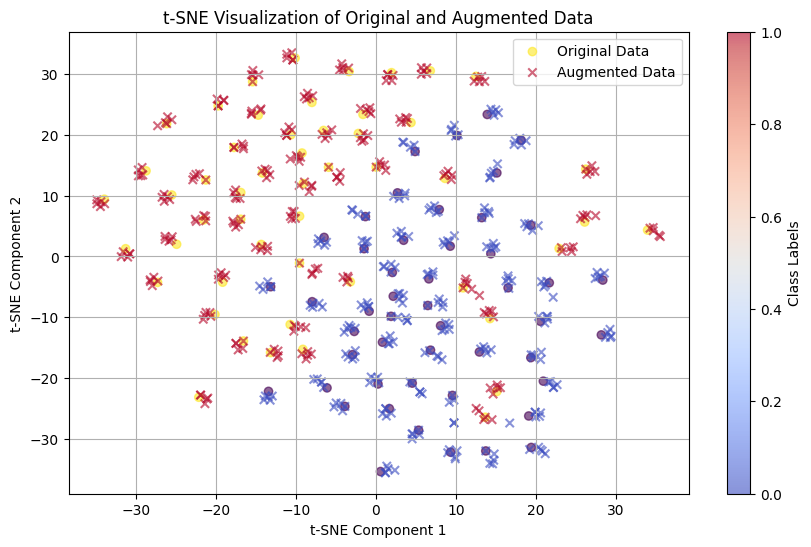

In [44]:
# Orijinal ve augmented verilerin görselleştirilmesi
visualize_tsne(
    original_embeddings=X_test_embeddings,
    augmented_embeddings=X_back_translation_embeddings_5,
    labels_original=y_test,
    labels_augmented=y_augmented_5
)

Combined Accuracy: 0.92
F1 Score: 0.9196146126053794
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        49
           1       1.00      0.84      0.91        51

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Confusion Matrix:
[[49  0]
 [ 8 43]]


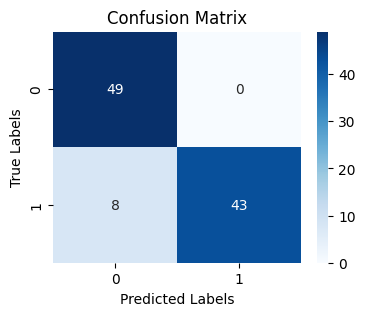

In [48]:
from scipy.stats import mode
import seaborn as sns

# Augmented veri için tahminler
aug_predictions = model.predict(X_back_translation_embeddings_5)

# Orijinal test verisi için tahminler
original_predictions = model.predict(X_test_embeddings)

# Augmented tahminleri, her orijinal test örneğiyle eşleştir
# Augmented veriyi oluştururken her test örneği için 3 varyasyon yaptığınızdan bunu hesaba katıyoruz.
aug_predictions = aug_predictions.reshape(len(X_test), 5)  # Her test örneği için 3 tahmin

# Karar birleştirme (Majority Voting)
final_predictions = []
for i in range(len(original_predictions)):
    # Orijinal tahmin + 3 augment tahmini
    combined_predictions = list(aug_predictions[i]) + [original_predictions[i]]
    # En sık geçen sınıfı seç
    final_decision = mode(combined_predictions).mode
    final_predictions.append(final_decision)

# Performansı değerlendirme
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Birleştirilmiş tahminlerle doğruluk hesaplama
combined_accuracy = accuracy_score(y_test, final_predictions)
print(f"Combined Accuracy: {combined_accuracy}")
print("F1 Score:", f1_score(y_test, final_predictions, average='weighted'))

# Detaylı rapor
print("Classification Report:")
print(classification_report(y_test, final_predictions))

# Karışıklık matrisi
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(cm)
# Heatmap çizimi
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [49]:
# Yanlış tahmin edilen indeksleri belirle
incorrect_indices = [i for i, (pred, true) in enumerate(zip(final_predictions, y_test)) if pred != true]

# Yanlış tahmin edilen örnekleri görüntüle
incorrect_samples = { "Original Pred": [original_predictions[i] for i in incorrect_indices],
    "Augmented Variants": [aug_predictions[i].tolist() for i in incorrect_indices],
    "Final Prediction": [final_predictions[i] for i in incorrect_indices],
    "True Label": [y_test[i] for i in incorrect_indices],
}
incorrect_df = pd.DataFrame(incorrect_samples)
incorrect_df

,Original Pred,Augmented Variants,Final Prediction,True Label
0,0,"[1, 0, 0, 0, 0]",0,1
1,1,"[0, 0, 0, 1, 0]",0,1
2,0,"[0, 0, 0, 0, 0]",0,1
3,0,"[0, 0, 0, 0, 0]",0,1
4,0,"[0, 0, 0, 0, 0]",0,1
5,1,"[0, 1, 0, 0, 0]",0,1
6,0,"[1, 0, 1, 1, 0]",0,1
7,0,"[0, 0, 0, 0, 0]",0,1


## Random Deletion

In [32]:
import random

# Random Deletion Fonksiyonu
def random_deletion(words, p=0.2):
    """
    Random Deletion: Bir cümledeki kelimeleri belirli bir olasılıkla siler.
    :param words: Cümleyi oluşturan kelimeler listesi.
    :param p: Silme olasılığı (0 ile 1 arasında).
    :return: Silme işlemi yapılmış yeni kelime listesi.
    """
    if len(words) == 1:
        return words  # Tek kelime varsa hiçbir şey silme

    new_words = []
    for word in words:
        if random.uniform(0, 1) > p:  # Kelimeyi silme olasılığı
            new_words.append(word)

    # Eğer tüm kelimeler silinmişse en az bir kelime bırak
    if len(new_words) == 0:
        new_words.append(random.choice(words))

    return new_words

# Random Deletion ile Augmentation
def augment_data_random_deletion_series(X_text, num_aug=3, p=0.2):
    """
    Random deletion yöntemiyle pandas.Series verisini genişletir.
    :param X_text: Orijinal test verisi (pandas.Series).
    :param num_aug: Her cümle için kaç augment yapılacağı.
    :param p: Silme olasılığı.
    :return: Augment edilmiş cümlelerin pandas.Series olarak döndürülmesi.
    """
    augmented_sentences = []
    for sentence in X_text:
        words = sentence.split()
        augmented = [random_deletion(words, p=p) for _ in range(num_aug)]
        augmented_sentences.extend([" ".join(sent) for sent in augmented])

    return augmented_sentences

In [36]:
augmented_X_test = augment_data_random_deletion_series(X_test, num_aug=3, p=0.3)

In [37]:
augmented_X_test

['not in this escapade works but coppola along with his sister a filmmaker',
 'not in this ambitious comic escapade works but coppola along with sister sofia a real filmmaker',
 'everything in this ambitious comic escapade works but coppola along with his sister sofia is a real filmmaker',
 'not enough',
 'just not campy enough',
 'just not campy',
 'all hallmarks of movie strictly children is home video market so it absorbs all manner of as year olds it diverting',
 'has the hallmarks movie for home video a market insatiable absorbs all of lame entertainment as long olds find it diverting',
 'has all of a designed strictly for children video market so insatiable it absorbs all manner of lame entertainment as olds find it diverting',
 'the ensemble cast turns in a collectively performance and the writing tight truthful of funny and',
 'the ensemble turns in a performance and tight and truthful of situations and honest observations',
 'ensemble cast turns in collectively stellar and the

In [39]:
deletion_augmented_test = pd.DataFrame({'text': augmented_X_test, 'label': y_test.repeat(3)})
X_deletion_embeddings = SentenceTransformer("intfloat/multilingual-e5-large-instruct").encode(deletion_augmented_test['text'].tolist(),batch_size=32,show_progress_bar=True)
y_augmented = deletion_augmented_test['label']

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-40-63f050c2c406>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Sınıflar için farklı renkler


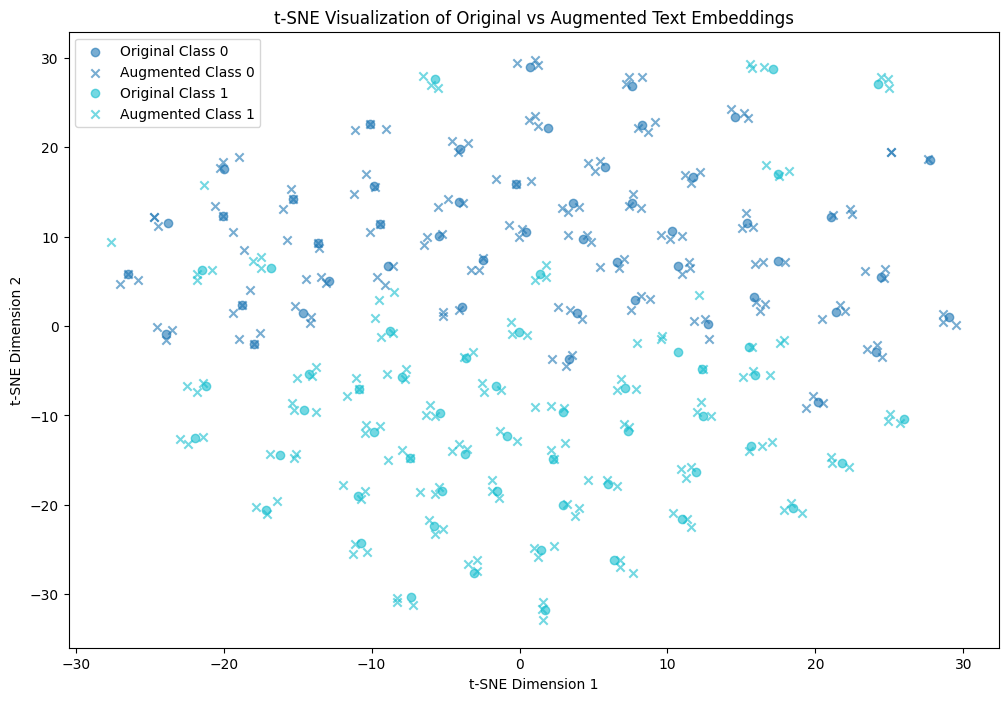

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# t-SNE Görselleştirme
def plot_tsne_embeddings(original_embeddings, augmented_embeddings, original_labels, augmented_labels):
    """
    Orijinal ve augment edilmiş embedding'leri sınıf etiketlerine göre t-SNE ile görselleştirir.
    :param original_embeddings: Orijinal metin embedding'leri (numpy array).
    :param augmented_embeddings: Augment edilmiş metin embedding'leri (numpy array).
    :param original_labels: Orijinal metinlerin etiketleri (numpy array veya pandas.Series).
    :param augmented_labels: Augment edilmiş metinlerin etiketleri (numpy array veya pandas.Series).
    """
    # t-SNE Uygulama
    tsne = TSNE(n_components=2, random_state=42)
    combined_embeddings = np.vstack((original_embeddings, augmented_embeddings))
    tsne_results = tsne.fit_transform(combined_embeddings)

    # Orijinal ve augment edilmiş veriyi ayır
    original_tsne = tsne_results[:len(original_embeddings)]
    augmented_tsne = tsne_results[len(original_embeddings):]

    # Görselleştirme
    plt.figure(figsize=(12, 8))
    unique_labels = np.unique(np.concatenate((original_labels, augmented_labels)))
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Sınıflar için farklı renkler

    for i, label in enumerate(unique_labels):
        # Orijinal veri noktaları
        idx_original = (original_labels == label)
        plt.scatter(original_tsne[idx_original, 0], original_tsne[idx_original, 1],
                    label=f'Original Class {label}', alpha=0.6, color=colors(i))

        # Augment edilmiş veri noktaları
        idx_augmented = (augmented_labels == label)
        plt.scatter(augmented_tsne[idx_augmented, 0], augmented_tsne[idx_augmented, 1],
                    label=f'Augmented Class {label}', alpha=0.6, marker='x', color=colors(i))

    plt.legend()
    plt.title('t-SNE Visualization of Original vs Augmented Text Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# t-SNE Görselleştirme Çağrısı
plot_tsne_embeddings(
    X_test_embeddings,
    X_deletion_embeddings,
    original_labels=np.array(y_test),
    augmented_labels=np.array(y_augmented)
)


Combined Accuracy: 0.89
F1 Score: 0.8896140350877192
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        49
           1       0.95      0.82      0.88        51

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100

Confusion Matrix:
[[47  2]
 [ 9 42]]


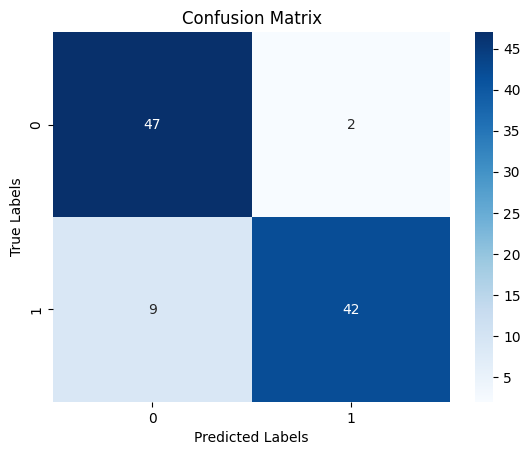

In [52]:
from scipy.stats import mode

# Augmented veri için tahminler
aug_predictions = model.predict(X_deletion_embeddings)

# Orijinal test verisi için tahminler
original_predictions = model.predict(X_test_embeddings)

# Augmented tahminleri, her orijinal test örneğiyle eşleştir
# Augmented veriyi oluştururken her test örneği için 3 varyasyon yaptığınızdan bunu hesaba katıyoruz.
aug_predictions = aug_predictions.reshape(len(X_test), 3)  # Her test örneği için 3 tahmin

# Karar birleştirme (Majority Voting)
final_predictions = []
for i in range(len(original_predictions)):
    # Orijinal tahmin + 3 augment tahmini
    combined_predictions = list(aug_predictions[i]) + [original_predictions[i]]
    # En sık geçen sınıfı seç
    final_decision = mode(combined_predictions).mode
    final_predictions.append(final_decision)

# Performansı değerlendirme
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Birleştirilmiş tahminlerle doğruluk hesaplama
combined_accuracy = accuracy_score(y_test, final_predictions)
print(f"Combined Accuracy: {combined_accuracy}")
print("F1 Score:", f1_score(y_test, final_predictions, average='weighted'))

# Detaylı rapor
print("Classification Report:")
print(classification_report(y_test, final_predictions))

# Karışıklık matrisi
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [53]:
# Yanlış tahmin edilen indeksleri belirle
incorrect_indices = [i for i, (pred, true) in enumerate(zip(final_predictions, y_test)) if pred != true]

# Yanlış tahmin edilen örnekleri görüntüle
incorrect_samples = { "Original Pred": [original_predictions[i] for i in incorrect_indices],
    "Augmented Variants": [aug_predictions[i].tolist() for i in incorrect_indices],
    "Final Prediction": [final_predictions[i] for i in incorrect_indices],
    "True Label": [y_test[i] for i in incorrect_indices],
}
incorrect_df = pd.DataFrame(incorrect_samples)
incorrect_df

,Original Pred,Augmented Variants,Final Prediction,True Label
0,0,"[0, 1, 0]",0,1
1,1,"[1, 0, 0]",0,1
2,0,"[1, 1, 1]",1,0
3,0,"[0, 1, 0]",0,1
4,1,"[0, 0, 1]",0,1
5,0,"[0, 0, 0]",0,1
6,0,"[0, 0, 0]",0,1
7,1,"[1, 0, 0]",0,1
8,1,"[0, 0, 0]",0,1
9,0,"[0, 0, 0]",0,1


Combined Accuracy with Weighted Voting: 0.93
F1 Score: 0.9297543859649123
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        49
           1       1.00      0.86      0.93        51

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100

Confusion Matrix:
[[49  0]
 [ 7 44]]


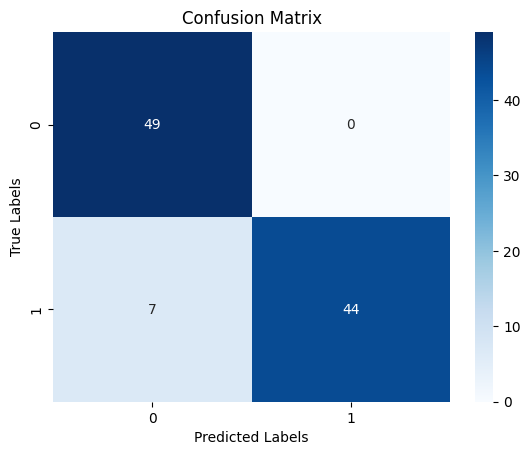

In [55]:
from scipy.stats import mode
import numpy as np

# Augmented tahminleri yeniden şekillendir (her test örneği için 3 tahmin)
aug_predictions = aug_predictions.reshape(len(X_test), 3)

# Ağırlıklandırma
weight = 3  # Orijinal tahminlere verilecek ağırlık
final_predictions = []

for i in range(len(original_predictions)):
    # Orijinal tahmini ağırlıklandır
    weighted_original = [original_predictions[i]] * weight
    # Orijinal ve augmented tahminleri birleştir
    combined_predictions = list(aug_predictions[i]) + weighted_original
    # En sık geçen sınıfı seç
    final_decision = mode(combined_predictions, keepdims=True).mode[0]  # keepdims parametresi eklendi
    final_predictions.append(final_decision)

# Performansı değerlendirme
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ağırlıklı birleştirilmiş tahminlerle doğruluk hesaplama
combined_accuracy = accuracy_score(y_test, final_predictions)
print(f"Combined Accuracy with Weighted Voting: {combined_accuracy}")
print("F1 Score:", f1_score(y_test, final_predictions, average='weighted'))

# Detaylı rapor
print("Classification Report:")
print(classification_report(y_test, final_predictions))

# Karışıklık matrisi
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## 5 katına çıkarma

In [56]:
#augmented_X_test
deletion_augmented_X_test_5 = augment_data_random_deletion_series(X_test, num_aug=5, p=0.3)

In [58]:
deletion_augmented_X_test_5

['not everything in this ambitious escapade works but along with sister sofia a real filmmaker',
 'not everything this ambitious comic escapade works but with sofia a filmmaker',
 'everything in this ambitious escapade works but along sister sofia is filmmaker',
 'not in this ambitious comic escapade but coppola along his sofia is a filmmaker',
 'this escapade works but coppola along his sofia is a real',
 'just not enough',
 'just campy enough',
 'just not campy enough',
 'just not',
 'not campy enough',
 'has the of a movie designed for children is home video a market so insatiable it all manner of lame long as year olds find it diverting',
 'has all the hallmarks of a movie designed strictly children is home video market so insatiable it all manner of lame entertainment as olds find diverting',
 'has all the of designed for children is video a market so insatiable all manner of entertainment long as find diverting',
 'has the hallmarks designed home a market so insatiable it absorbs

In [59]:
deletion_augmented_test_5 = pd.DataFrame({'text': deletion_augmented_X_test_5, 'label': y_test.repeat(5)})
X_deletion_embeddings_5 = SentenceTransformer("intfloat/multilingual-e5-large-instruct").encode(deletion_augmented_test_5['text'].tolist(),batch_size=32,show_progress_bar=True)
y_augmented_5 = deletion_augmented_test_5['label']

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-40-63f050c2c406>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Sınıflar için farklı renkler


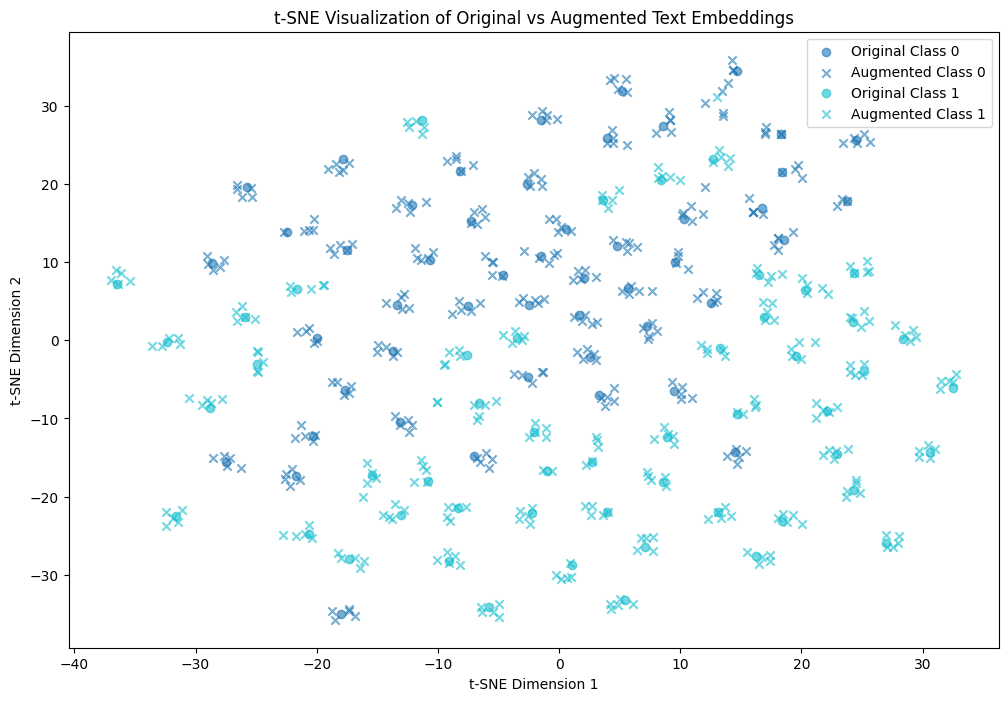

In [60]:
# t-SNE Görselleştirme Çağrısı
plot_tsne_embeddings(
    X_test_embeddings,
    X_deletion_embeddings_5,
    original_labels=np.array(y_test),
    augmented_labels=np.array(y_augmented_5)
)

Combined Accuracy: 0.91
F1 Score: 0.9098648783905514
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        49
           1       0.96      0.86      0.91        51

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

Confusion Matrix:
[[47  2]
 [ 7 44]]


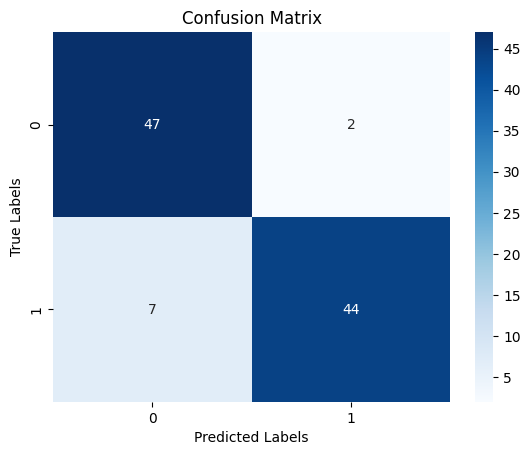

In [62]:
from scipy.stats import mode

# Augmented veri için tahminler
aug_predictions = model.predict(X_deletion_embeddings_5)

# Orijinal test verisi için tahminler
original_predictions = model.predict(X_test_embeddings)

# Augmented tahminleri, her orijinal test örneğiyle eşleştir
# Augmented veriyi oluştururken her test örneği için 3 varyasyon yaptığınızdan bunu hesaba katıyoruz.
aug_predictions = aug_predictions.reshape(len(X_test), 5)  # Her test örneği için 3 tahmin

# Karar birleştirme (Majority Voting)
final_predictions = []
for i in range(len(original_predictions)):
    # Orijinal tahmin + 3 augment tahmini
    combined_predictions = list(aug_predictions[i]) + [original_predictions[i]]
    # En sık geçen sınıfı seç
    final_decision = mode(combined_predictions).mode
    final_predictions.append(final_decision)

# Performansı değerlendirme
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Birleştirilmiş tahminlerle doğruluk hesaplama
combined_accuracy = accuracy_score(y_test, final_predictions)
print(f"Combined Accuracy: {combined_accuracy}")
print("F1 Score:", f1_score(y_test, final_predictions, average='weighted'))

# Detaylı rapor
print("Classification Report:")
print(classification_report(y_test, final_predictions))

# Karışıklık matrisi
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [64]:
# Yanlış tahmin edilen indeksleri belirle
incorrect_indices = [i for i, (pred, true) in enumerate(zip(final_predictions, y_test)) if pred != true]

# Yanlış tahmin edilen örnekleri görüntüle
incorrect_samples = { "Original Pred": [original_predictions[i] for i in incorrect_indices],
    "Augmented Variants": [aug_predictions[i].tolist() for i in incorrect_indices],
    "Final Prediction": [final_predictions[i] for i in incorrect_indices],
    "True Label": [y_test[i] for i in incorrect_indices],
}
incorrect_df = pd.DataFrame(incorrect_samples)
incorrect_df

,Original Pred,Augmented Variants,Final Prediction,True Label
0,0,"[0, 1, 0, 0, 0]",0,1
1,1,"[1, 0, 0, 1, 0]",0,1
2,1,"[1, 0, 0, 1, 0]",0,1
3,0,"[0, 0, 1, 1, 0]",0,1
4,0,"[0, 0, 0, 0, 0]",0,1
5,0,"[1, 1, 1, 0, 1]",1,0
6,0,"[0, 0, 1, 0, 0]",0,1
7,0,"[0, 1, 1, 1, 1]",1,0
8,0,"[0, 0, 0, 0, 1]",0,1


Combined Accuracy with Weighted Voting: 0.95
F1 Score: 0.9499249324391953
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        49
           1       1.00      0.90      0.95        51

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Confusion Matrix:
[[49  0]
 [ 5 46]]


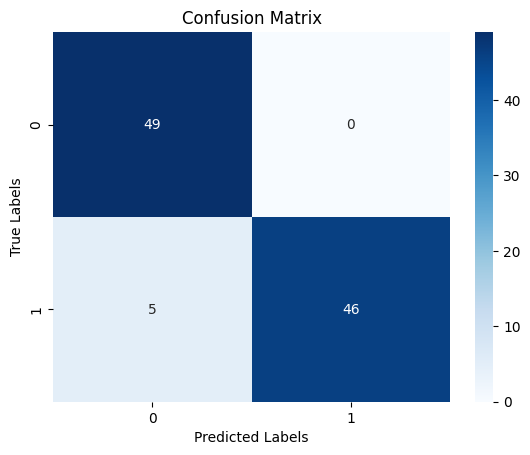

In [66]:
from scipy.stats import mode
import numpy as np

# Augmented tahminleri yeniden şekillendir (her test örneği için 3 tahmin)
aug_predictions = aug_predictions.reshape(len(X_test), 5)

# Ağırlıklandırma
weight = 3  # Orijinal tahminlere verilecek ağırlık
final_predictions = []

for i in range(len(original_predictions)):
    # Orijinal tahmini ağırlıklandır
    weighted_original = [original_predictions[i]] * weight
    # Orijinal ve augmented tahminleri birleştir
    combined_predictions = list(aug_predictions[i]) + weighted_original
    # En sık geçen sınıfı seç
    final_decision = mode(combined_predictions, keepdims=True).mode[0]  # keepdims parametresi eklendi
    final_predictions.append(final_decision)

# Performansı değerlendirme
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ağırlıklı birleştirilmiş tahminlerle doğruluk hesaplama
combined_accuracy = accuracy_score(y_test, final_predictions)
print(f"Combined Accuracy with Weighted Voting: {combined_accuracy}")
print("F1 Score:", f1_score(y_test, final_predictions, average='weighted'))

# Detaylı rapor
print("Classification Report:")
print(classification_report(y_test, final_predictions))

# Karışıklık matrisi
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()